In [46]:
# load libraries
library(tidyverse)

In [47]:
# load data
df <- read.csv(file.path("data", "clean.csv"))
overall <- read.csv(file.path("data", "overall.csv"))
words <- read.csv(file.path("data", "words.csv"))

In [96]:
# calculate scores for ranking stories
scores <- df %>%
    group_by(story_index) %>%
    summarize(score1 = mean(abs(mean_2 - mean_3)),
              score2 = max(abs(mean_2 - mean_3)),
              score3 = mean(diff(sign(mean_2 - mean_3)) != 0),
              score4 = 1 - abs(cor(mean_2, mean_3)),
              score5 = 0.5 * score1 + 0.2 * score2 + 0.3 * score4,
              score6 = mean(abs(mean_2)) + mean(abs(mean_3)),
              score7 = mean(mean_2^2) + mean(mean_3^2),
              score8 = mean((mean_2-mean_3)^2),
              score9 = mean((max_2-max_3)^2),
              score10 = 1 - abs(cor(max_2, max_3))) %>%
    arrange(score10)

# get top 8 stories by index
i_opt <- head(scores$story_index, 8)
i_opt

[1] 69 86 78 44 48 39 15 30

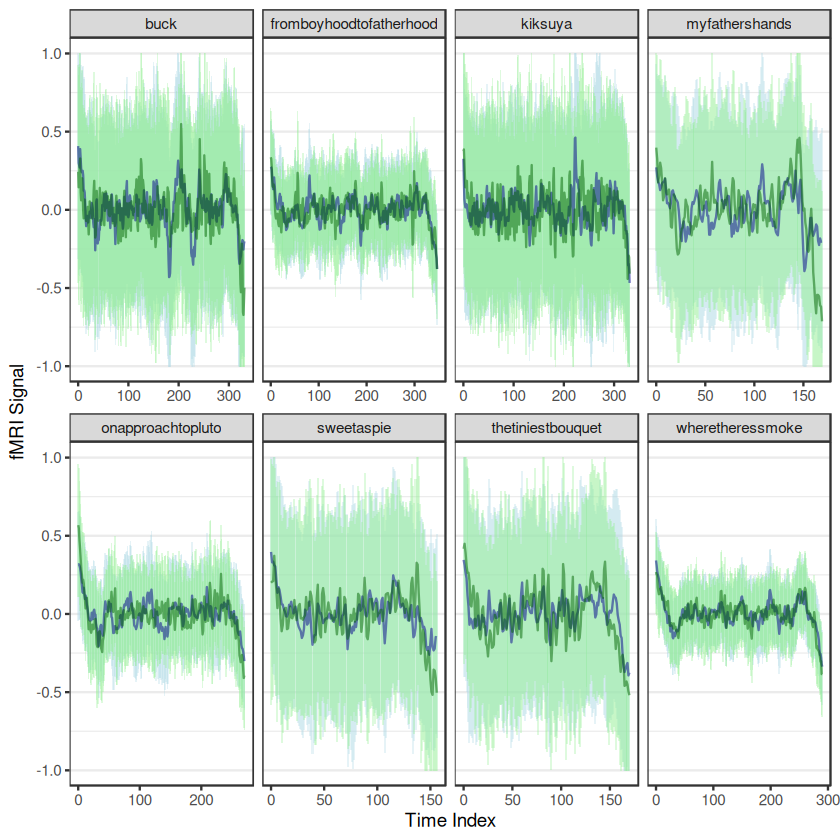

In [87]:
# create df1
df1 <- df %>%
    filter(story_index %in% i_opt)

# adjust plot limits
limits <- c(min(df1$mean_2, df1$mean_3), max(df1$mean_2, df1$mean_3))
sc <- function(x) {ifelse(abs(x) > 1, sign(x) * 1, x)}

# create plot1
plot1 <- ggplot(df1) +
    facet_wrap(story_name~., nrow=2, scales="free_x") +
    #facet_grid(story_index~.) +
    geom_rect(aes(xmin=time_index-0.5, xmax=time_index+0.5, ymin=sc(q_25_2), ymax=sc(q_75_2)),
              fill="lightblue", alpha=0.3, color=NA) +
    geom_rect(aes(xmin=time_index-0.5, xmax=time_index+0.5, ymin=sc(q_25_3), ymax=sc(q_75_3)),
              fill="lightgreen", alpha=0.3, color=NA) +
    geom_line(aes(x=time_index,  y=mean_2), color="darkblue", alpha=0.5) + 
    geom_line(aes(x=time_index,  y=mean_3), color="darkgreen", alpha=0.5) +
    scale_y_continuous(limits=c(-1,1)) +
    labs(y="fMRI Signal",
         x="Time Index") +
    theme_bw() + theme(panel.grid.major.x = element_blank(),
                       panel.grid.minor.x = element_blank(),
                       strip.text.y.right = element_text(angle = 0))

# output plot1
plot1

In [74]:
# save plot1 to file
ggsave("mean_signal.png", plot1, width=14, height=7)

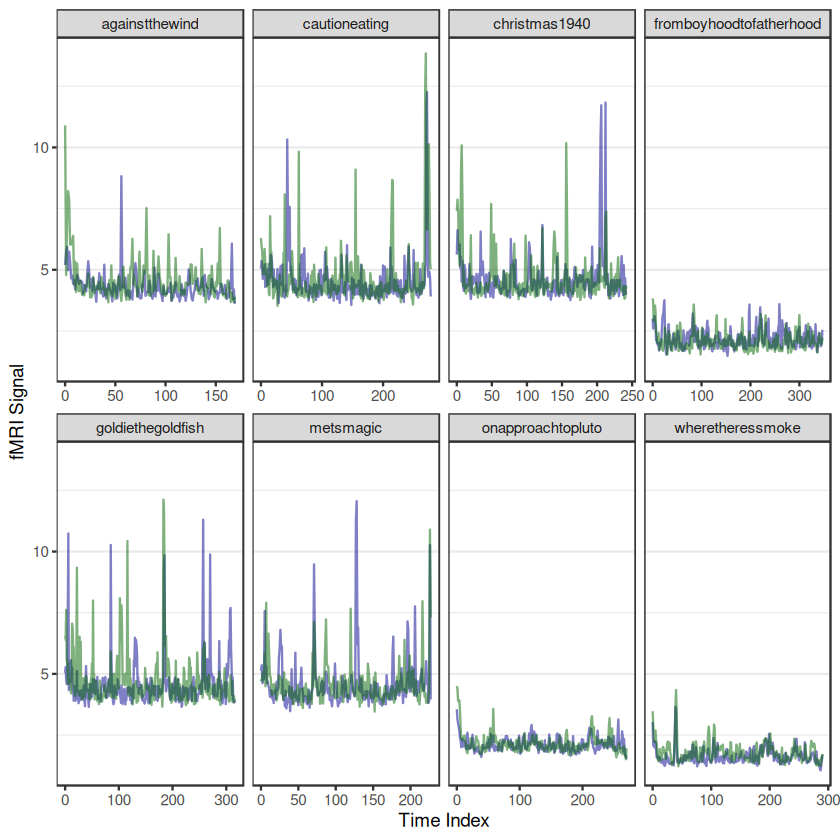

In [113]:
# create df2
df2 <- df %>%
    filter(story_index %in% i_opt)

# adjust plot limits
limits <- c(min(df1$mean_2, df1$mean_3), max(df1$mean_2, df1$mean_3))
sc <- function(x) {x} #{ifelse(abs(x) > 1, sign(x) * 1, x)}

# create plot2
plot2 <- ggplot(df2) +
    facet_wrap(story_name~., nrow=2, scales="free_x") +
    #facet_grid(story_index~.) +
    #geom_rect(aes(xmin=time_index-0.5, xmax=time_index+0.5, ymin=sc(q_25_2), ymax=sc(q_75_2)),
    #          fill="lightblue", alpha=0.3, color=NA) +
    #geom_rect(aes(xmin=time_index-0.5, xmax=time_index+0.5, ymin=sc(q_25_3), ymax=sc(q_75_3)),
    #          fill="lightgreen", alpha=0.3, color=NA) +
    geom_line(aes(x=time_index,  y=sc(max_2)), color="darkblue", alpha=0.5) + 
    geom_line(aes(x=time_index,  y=sc(max_3)), color="darkgreen", alpha=0.5) +
    #scale_y_continuous(limits=c(1,15)) +
    labs(y="fMRI Signal",
         x="Time Index") +
    theme_bw() + theme(panel.grid.major.x = element_blank(),
                       panel.grid.minor.x = element_blank(),
                       strip.text.y.right = element_text(angle = 0))

# output plot2
plot2

In [98]:
# save plot2 to file
ggsave("max_signal.png", plot2, width=14, height=7)

`summarise()` has grouped output by 'story_index'. You can override using the
`.groups` argument.


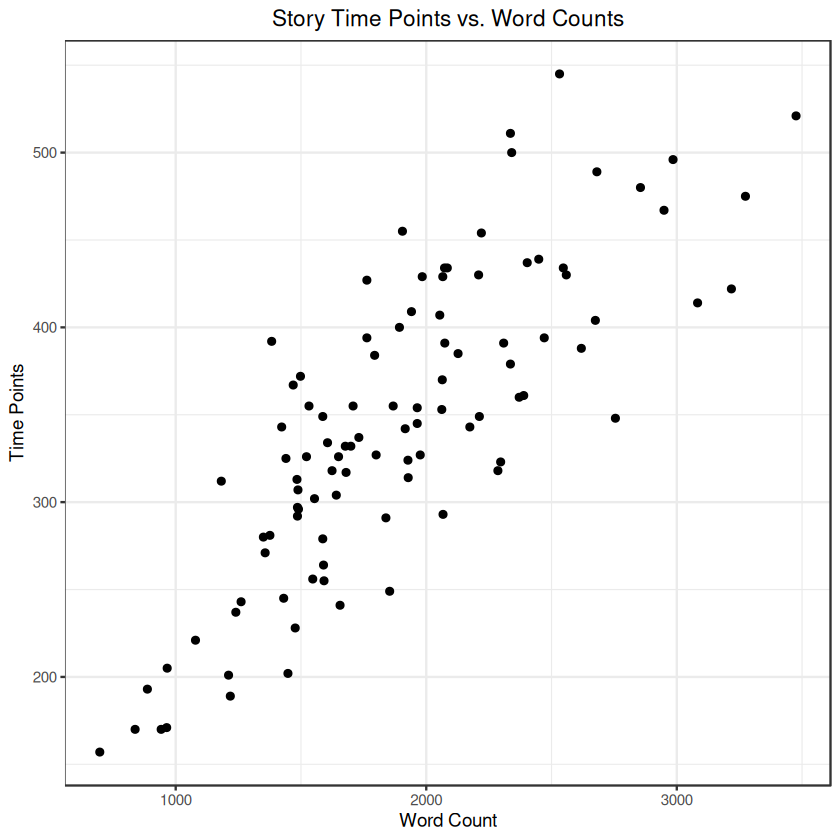

In [127]:
# create df4
df4 <- df %>%
    group_by(story_index, story_name) %>%
    summarize(points = max(time_index) + 1) %>%
    left_join(words, by=c("story_index"="story_index", "story_name"="story_name")) %>%
    arrange(-words)

# create plot4
plot4 <- df4 %>% ggplot() +
    #geom_bar(aes(y=words, x=reorder(story_name, words)), stat="identity", fill="green") +
    #geom_bar(aes(y=points, x=reorder(story_name, words)), stat="identity", fill="red") +
    #labs(y="Count",
    #     x="Story",
    #     title="Stories by Word Count and Time Points") +
    #theme_bw() + theme(plot.title = element_text(hjust=0.5),
    #                   axis.text.x = element_text(size=4, angle=30, vjust=1, hjust=1))
    geom_point(aes(x=words, y=points)) +
    labs(title="Story Time Points vs. Word Counts",
         x="Word Count",
         y="Time Points") +
    theme_bw() + theme(plot.title = element_text(hjust=0.5))

# output plot4
plot4

In [ ]:
# save plot4 to file
ggsave("word_count.png", plot5, width=5, height=5)

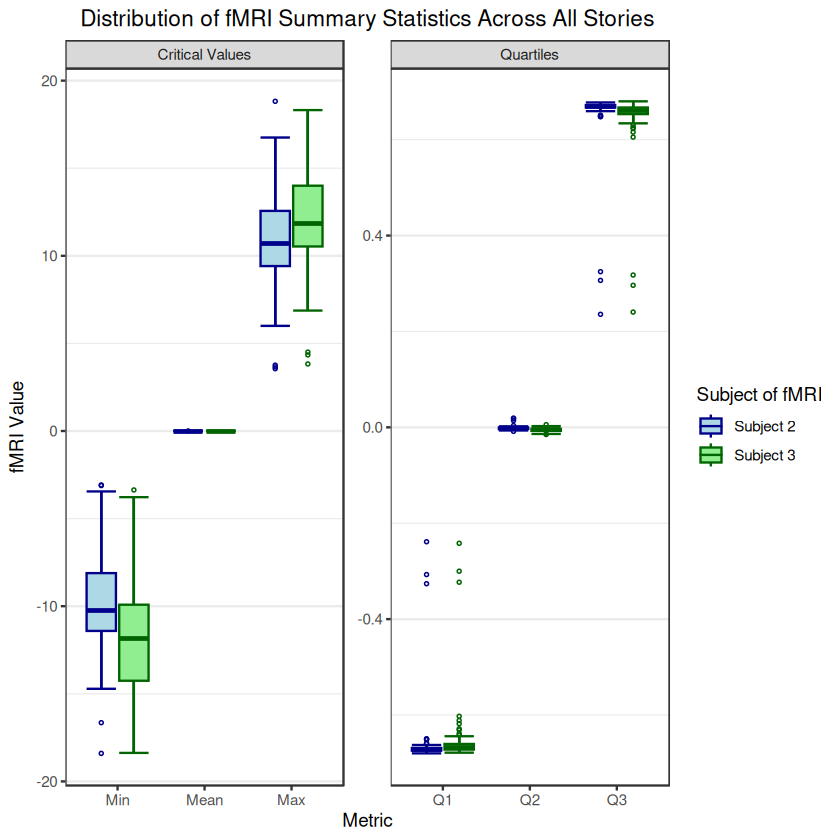

In [75]:
# create df5
df5 <- overall %>%
    select(-nans_2, -nans_3, -infs_2, -infs_3) %>%
    pivot_longer(!c(story_index, story_name), names_to="stat", values_to="value") %>%
    mutate(subject = str_sub(stat, -1),
           subject = factor(subject, levels = c(2, 3), labels = c("Subject 2", "Subject 3")),
           nstat = str_sub(stat, 1, -3),
           nstat = factor(nstat,
                          levels = c("min", "q_25", "mean", "q_50", "q_75", "max"),
                          labels = c("Min", "Q1", "Mean", "Q2", "Q3", "Max")),
          facet = ifelse(str_sub(stat, 1, 1) == "q", 2, 1),
          facet = factor(facet, levels=c(1, 2), labels=c("Critical Values", "Quartiles")),
          stat_facet = paste(stat, facet, sep="_"))


# create plot5
plot5 <- df5 %>%
    ggplot(aes(y=value, x=nstat, group=stat, fill=subject, color=subject)) +
    stat_boxplot(geom ='errorbar') +
    geom_boxplot(outlier.shape=1, outlier.size=0.5) +
    facet_wrap(.~facet, scales="free") +
    
    scale_fill_manual(values=c("lightblue", "lightgreen"), name="Subject of fMRI") +
    scale_color_manual(values=c("darkblue", "darkgreen"), name="Subject of fMRI") +
    labs(title="Distribution of fMRI Summary Statistics Across All Stories",
         x = "Metric",
         y = "fMRI Value") +
    theme_bw() + theme(plot.title=element_text(hjust=0.5),
                       panel.grid.major.x = element_blank(),
                       panel.grid.minor.x = element_blank())

# output plot5
plot5

In [76]:
# save plot5 to file
ggsave("boxplots.png", plot5, width=8, height=5)

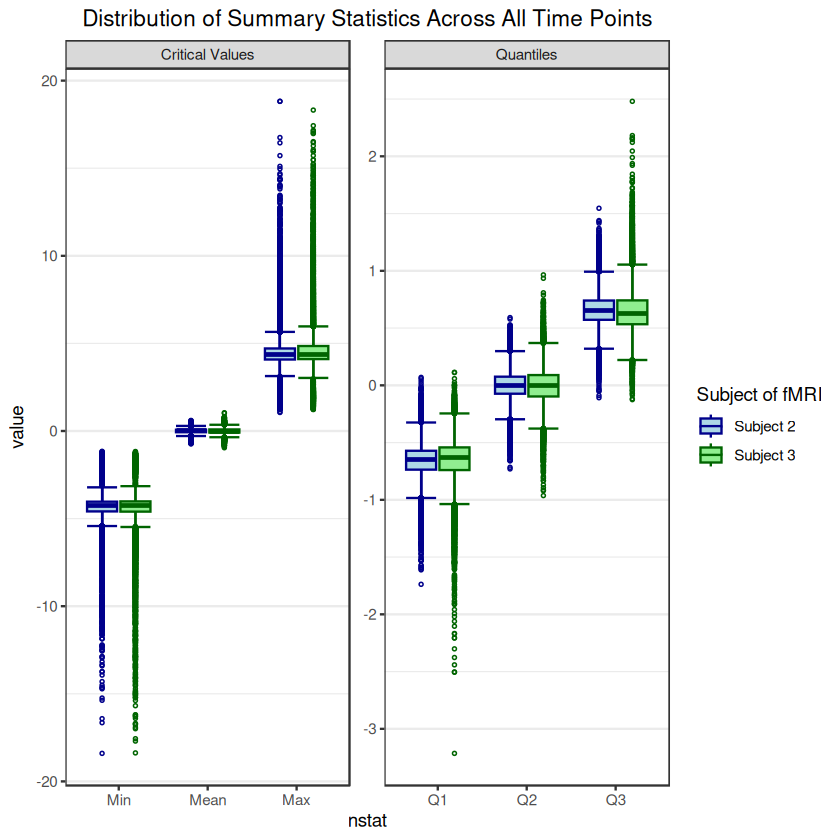

In [114]:
# creae df6
df6 <- df %>%
    select(-nans_2, -nans_3, -infs_2, -infs_3) %>%
    pivot_longer(!c(story_index, story_name, time_index), names_to="stat", values_to="value") %>%
    mutate(subject = str_sub(stat, -1),
           subject = factor(subject, levels = c(2, 3), labels = c("Subject 2", "Subject 3")),
           nstat = str_sub(stat, 1, -3),
           nstat = factor(nstat,
                          levels = c("min", "q_25", "mean", "q_50", "q_75", "max"),
                          labels = c("Min", "Q1", "Mean", "Q2", "Q3", "Max")),
          facet = ifelse(str_sub(stat, 1, 1) == "q", 2, 1),
          facet = factor(facet, levels=c(1, 2), labels=c("Critical Values", "Quantiles")),
          stat_facet = paste(stat, facet, sep="_")) %>%
    group_by(stat) %>%
    mutate(outlier_lwr = value < quantile(value, probs = 0.25) - IQR(value) * 1.5,
           outlier_upr = value > quantile(value, probs = 0.75) + IQR(value) * 1.5,
           outlier = ifelse(outlier_lwr | outlier_upr, value, NA)) %>%
    ungroup()

# create plot6
plot6 <- df6 %>%
    ggplot(aes(y=value, x=nstat, group=stat, fill=subject, color=subject)) +
    stat_boxplot(geom ='errorbar') +
    geom_boxplot(outlier.shape=1, outlier.size=0.5) +
    #geom_jitter(aes(y=outlier, x=nstat), width = 0.2, size=0.5, shape=1, alpha=0.5) +
    facet_wrap(.~facet, scales="free") +
    
    scale_fill_manual(values=c("lightblue", "lightgreen"), name="Subject of fMRI") +
    scale_color_manual(values=c("darkblue", "darkgreen"), name="Subject of fMRI") +
    labs(title="Distribution of Summary Statistics Across All Time Points") +
    theme_bw() + theme(plot.title=element_text(hjust=0.5),
                       panel.grid.major.x = element_blank(),
                       panel.grid.minor.x = element_blank())

# output plot6
plot6